In [885]:
import wandb
#from wandb import Api
from collections import defaultdict
import pandas as pd
import numpy as np

import random

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display_html
import os

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [886]:
#BASELINES = ["DBMS\n(Diff DB,Test Env)", "DBMS\n(Test DB,Test Env)"]

#BASELINES = ["DBMS", "DBMS (DB, Same Env)"]

BASELINES = ["DBMS"]
HUES = {}

HUES["DBMS"] = "Red"  # Red is a strong color, good for contrast.
HUES["DBMS (DB, Same Env)"] = "Orange"  # Orange is distinct from red and provides good contrast.

# Your model
HUES["Factorized (Osprey)"] = "RoyalBlue"  # A bright and prominent shade of blue.

# Other GCN models
HUES["GCN (DB, New Env)"] = "LightGreen"  # A lighter shade for distinction from darker colors.
HUES["GCN (Transferable)"] = "Cyan"  # Cyan is visually distinct from blue and green.
HUES["GCN (DB, Same Env)"] = "LightGray"  # A neutral, unobtrusive color for the least focus.

# Factorized (Osprey) models
HUES["Factorized (Osprey)\n(No Pre-training)"] = "YellowGreen"  # A yellow-green shade for differentiation.

# GCN-Transformer models
HUES["GCN-Transformer (TestDB)"] = "SlateGray"  # A neutral color that doesn't dominate.

In [887]:
api = wandb.Api()

In [888]:
bruns = api.runs("pari/LatencyPredictor",
    {"$and": [
      {"config.alg": "dbms"},
      {"$or": [
            {"$and": [
                #{"tags":"single_baseline_zdbs"},
                {"tags":"zdb-single-baseline2"},
            ]},
      ]} 
    ]
    })

print(f"Found {len(bruns)} runs")

Found 4 runs


In [889]:
import time
start = time.time()

bdfs = []

cur_run = None
for run in bruns:
    skip = False
    if skip:
        continue
    if run.State != "finished":
        print("not finished!")
        cur_run = run
        continue
    
    data = defaultdict(list)
    data["Tags"].append(run.Tags)
    data["name"].append(run.name)
    
    for k,v in run.config.items():
        if not k.startswith("_") or not k.contains("/"):
            data[k].append(v)

    for k,v in run.summary._json_dict.items():
        if k.startswith("_"):
            continue
        if "/" in k:
            continue
        data[k].append(v)
        
    bdfs.append(pd.DataFrame(data))

print("took: ", time.time()-start)
print(len(bdfs))

bdf = pd.concat(bdfs)
#bdf = bdf[bdf["config"] == "configs/baselines/config_dbms_imdb.yaml"]
print(len(bdf))

took:  0.02461695671081543
4
4


In [890]:
# print(data["only_workload"])
# print(data["name"])

def fix_zdb_only_wk(row):
    if row["test_query_dir"] is not None and row["only_workload"] == "":
        return os.path.basename(row["test_query_dir"])
    return row["only_workload"]

bdf["only_workload"] = bdf.apply(lambda x: fix_zdb_only_wk(x), axis=1)

In [891]:
bdf[["Final-LatencyQError-test-mean", "Final-LatencyQError-test_unseen-mean",  "dbms_fit_test", "only_workload", 
    "test_query_dir"]]

,Final-LatencyQError-test-mean,Final-LatencyQError-test_unseen-mean,dbms_fit_test,only_workload,test_query_dir
0,37.462005,36.339727,0,airline,./queries/airline
0,13.778776,12.903280,0,accidents,./queries/accidents
0,19.434033,13.146012,0,ssb,./queries/ssb
0,33.972373,37.871356,0,ccs,./queries/ccs


In [892]:
#bdf = bdf[bdf["dbms_fit_test"] == 1]

In [893]:
runs = api.runs("pari/LatencyPredictor",
    {"$and": [
      #{"config.eval_epoch": 5},
      #{"config.traindata_dir": "LatencyCollectorResults/background"},
      #{"config.traindata_dir": "LatencyCollectorResults/new"},
      {"$or": [
            {"$or": [
                #{"tags":"final2"},
                #{"tags":"final-min-01"},
                #{"tags":"final2-min-01"},
                #{"tags":"final4-fixed_instances-min-1"},
                #{"tags": "all-final4-fixed_instances-min-1"},
                #{"tags": "final5-fixed_instances-min-1"},
                #{"tags": "single-final7-min-01"},
                {"tags": "single-zdbs-final9-min-01"},
                {"tags": "zdbs-transferable"},
            ]},
#           {
#             "config.config":  "configs/baselines/config_avg.yaml",
#           },
#           {
#             "config.config":  "configs/baselines/config_trans.yaml",
#           },
      ]} 
    ]
    })

print(f"Found {len(runs)} runs")

Found 234 runs


In [894]:
import time
start = time.time()

dfs = []

cur_run = None
for run in runs:
    skip = False
    if skip:
        continue
    if run.State != "finished":
        cur_run = run
        continue
    
    data = defaultdict(list)
    data["Tags"].append(run.Tags)
    data["name"].append(run.name)
    
    
    for k,v in run.config.items():
        if not k.startswith("_") or not k.contains("/"):
            data[k].append(v)

    for k,v in run.summary._json_dict.items():
        if k.startswith("_"):
            continue
        if "/" in k:
            continue
        data[k].append(v)
        
    dfs.append(pd.DataFrame(data))

print("took: ", time.time()-start)
print(len(dfs))

took:  1.946148157119751
221


In [895]:
df = pd.concat(dfs)
#df = df[df["tags"] == "exp1_single,exp2_single,exp3_single,exp7_single_ceb2"]

df1 = df[df["config"].str.contains("transfer")]
print("Num transferrable: ", len(df1))
df1 = df[df["feat_onehot"] == 0]
df1['fixed_tr'] = df1['Tags'].apply(lambda x: any("transfer" in s for s in x))
df1 = df1[df1['fixed_tr']]
df1["only_workload"] = df1.apply(lambda x: fix_zdb_only_wk(x), axis=1)
print("Num transferrable: ", len(df1))

df2 = df[df["split_kind"] == "lt_type-query"]

#df = df[df["lr"] == 0.0001]

df = pd.concat([df1, df2, bdf])
print(len(df))

Num transferrable:  24
Num transferrable:  24
225


In [896]:
set(df["alg"])

{'dbms', 'nn'}

In [897]:
set(df["sys_net_pretrained_fn"])

{None,
 'models4/noimdb_log_nostatic_logfeats.wt',
 'models5/mixed_noergast_logfeats_col.wt',
 'models5/single_allzdbs_logfeats_col.wt',
 'models5/single_nossb_logfeats_col2.wt'}

In [898]:
# GCN, GCN-Transformer, GCN-Pretrained, GCN-Pretrained-Latent

PRETRAINED_NAME = False

def get_alg(row):
    if "dbms" == row["alg"] or "dbms-c" == row["alg"]:
        if row["dbms_fit_test"]:
            return "DBMS (DB, Same Env)"
        else:
            return "DBMS"
    
    elif "dbms-all" == row["alg"]:
        return "DBMS-all"
    
    elif "avg" in row["config"]:
        return "GCN-Avg"
    
    elif row["arch"] == "gcn":
        if "train_local_model" in row:
            if "train_env_model" in row and str(row["train_env_model"]) != "nan" and row["train_env_model"]:
                print(row["train_env_model"])
                #return "GCN\n(Diff DB,Test Env)"
                return "GCN (Transferable)"
            elif str(row["train_local_model"]) == "nan" or not row["train_local_model"]:
                #return "GCN\n(Test DB,Diff Env)"
                return "GCN (DB, New Env)"
            else:
                #return "GCN\n(Test DB,Test Env)"
                return "GCN (DB, Same Env)"
        else:
            return "GCN"
    
    elif row["sys_net_pretrained"] == 0:
        if row["extra_training"]:
            return "Factorized (Osprey)\n(No Pre-training)"
        else:
            return "GCN-Transformer (TestDB)"
    
    elif row["sys_net_pretrained"] == 0:
        return "GCN-Transformer"
    
    elif "evals" in row["config"]:
        if PRETRAINED_NAME:
            pn = row["sys_net_pretrained_fn"]
            mn = "GCN-Pretrained-" + str(row["lr"]) + "extra-training-" + str(row["extra_training"])
            mn += "wd-" + str(row["weight_decay"])
            mn += "-" + pn
            return mn
        else:
            if row["sys_net_pretrained_fn"] == "models5/single_nossb_logfeats_col2.wt":
                return "Factorized (Osprey)"
            elif row["sys_net_pretrained_fn"] == "models5/single_allzdbs_logfeats_col.wt":
                return "Factorized (Osprey)"
            else:
                return ""
    else:
        return None
    
def get_final_alg(row):
    if "dbms" == row["alg"] or "dbms-c" == row["alg"]:
        if row["dbms_fit_test"]:
            return "DBMS (DB, Same Env)"
        else:
            return "DBMS"
    
    elif "dbms-all" == row["alg"]:
        return "DBMS-all"
    
    elif "avg" in row["config"]:
        return "GCN-Avg"
    
    elif row["arch"] == "gcn":
        if "train_local_model" in row:
            if "train_env_model" in row and str(row["train_env_model"]) != "nan" and row["train_env_model"]:
                #print(row["train_env_model"])
                #return "GCN\n(Diff DB,Test Env)"
                return "GCN (Transferable)"
            elif str(row["train_local_model"]) == "nan" or not row["train_local_model"]:
                #return "GCN\n(Test DB,Diff Env)"
                return "GCN (DB, New Env)"
            else:
                #return "GCN\n(Test DB,Test Env)"
                return "GCN (DB, Same Env)"
        else:
            return "GCN"
    
    elif row["sys_net_pretrained"] == 0:
        if row["extra_training"]:
            return "Factorized (Osprey)\n(No Pre-training)"
        else:
            return "GCN-Transformer (TestDB)"
    
    elif row["sys_net_pretrained"] == 0:
        return "GCN-Transformer"
    
    elif "evals" in row["config"]:
        if PRETRAINED_NAME:
            pn = row["sys_net_pretrained_fn"]
            mn = "GCN-Pretrained-" + str(row["lr"]) + "extra-training-" + str(row["extra_training"])
            mn += "wd-" + str(row["weight_decay"])
            mn += "-" + pn
            return mn
        else:
            if row["sys_net_pretrained_fn"] == "models5/single_nossb_logfeats_col2.wt":
                return "Factorized (Osprey)"
            elif row["sys_net_pretrained_fn"] == "models5/single_allzdbs_logfeats_col.wt":
                return "Factorized (Osprey)"
            else:
                return ""
    else:
        return None
    
def get_workload(row):
    if "dbms" in row["alg"].lower():
        return "IMDb"
    
    if "stack" in row["tags"]:
        return "Stack"
    elif "tpch" in row["tags"]:
        return "Tpch"
    elif "zdb" in row["tags"]:
        return "zdbs"
    else:
        return "IMDb"
    
    
df["Estimator"] = df.apply(lambda x: get_final_alg(x),axis=1)
df["alg"] = df.apply(lambda x: get_alg(x),axis=1)
df["workload"] = df.apply(lambda x: get_workload(x),axis=1)

1.0
5.0
2.0
6.0
4.0
4.0
3.0
3.0
3.0
5.0
5.0
4.0
6.0
2.0
1.0
3.0
1.0
2.0
2.0
5.0
4.0
6.0
1.0
6.0


In [899]:
df = df[df["alg"].notna()]

In [900]:
print(len(df))
print(set(df["num_instances"]))
print(set(df["seed"]))
print(set(df["config"]))
print(set(df["sys_net_pretrained_fn"]))
print(set(df["alg"]))
print(set(df["tags"]))
print(set(df["workload"]))
print(set(df["tags"]))
print(df.keys())

225
{1}
{0, 1, 2, 3}
{'configs/evals/single/config_nozdb_transferable.yaml', 'configs/evals/single/config_nozdbs.yaml', 'configs/baselines/config_dbms_ccs.yaml'}
{'models5/single_nossb_logfeats_col2.wt', 'models4/noimdb_log_nostatic_logfeats.wt', 'models5/mixed_noergast_logfeats_col.wt', 'models5/single_allzdbs_logfeats_col.wt', None}
{'', 'GCN (DB, Same Env)', 'GCN-Transformer (TestDB)', 'GCN (DB, New Env)', 'DBMS', 'Factorized (Osprey)', 'GCN (Transferable)'}
{'exp11_single_zdbs', 'exp8_single_stack,exp9_single_tpch,exp4_single_ergast,exp1_single,exp2_single,exp3_single,exp7_single_ceb2,exp14_single_stack,exp10_single_zdbs,exp11_single_zdbs', 'exp10_single_zdbs,exp11_single_zdbs', 'exp10_single_zdbs'}
{'Stack', 'IMDb', 'zdbs'}
{'exp11_single_zdbs', 'exp8_single_stack,exp9_single_tpch,exp4_single_ergast,exp1_single,exp2_single,exp3_single,exp7_single_ceb2,exp14_single_stack,exp10_single_zdbs,exp11_single_zdbs', 'exp10_single_zdbs,exp11_single_zdbs', 'exp10_single_zdbs'}
Index(['Tags',

In [901]:
#df = df[df["alg"] != "DBMS-all"]
#df = df[df["alg"] != "GCN-Pretrained-Latent"]

In [902]:
print(len(df))
df.keys()

225


Index(['Tags', 'name', 'lr', 'alg', 'hl1', 'arch', 'seed', 'tags', 'config',
       'min_est',
       ...
       'new_env_unseen-LatencyQError', 'train-LatencyMSE',
       'train-LatencyRelError', 'train-train_loss', 'train-LatencyAE',
       'test-LatencyQError', 'new_env_unseen-LatencyAE', 'fixed_tr',
       'Estimator', 'workload'],
      dtype='object', length=243)

In [903]:
#df = df[df["weight_decay"] == 0.1]

In [904]:
pd.set_option('display.max_rows', 500)

tmp = df[df["num_instances"] == 1]

tmp = df[df["only_workload"] == "accidents"]
tmp[["seed", "num_instances", "alg", "extra_training", "weight_decay", "lr", "Final-LatencyQError-test_unseen-mean", "weight_decay",  ]].sort_values(by="seed")

,seed,num_instances,alg,extra_training,weight_decay,lr,Final-LatencyQError-test_unseen-mean,weight_decay
0,0,1,,0,1,0.00010,4.285427,1
0,0,1,GCN-Transformer (TestDB),0,1,0.00010,3.461436,1
0,0,1,"GCN (DB, New Env)",0,1,0.00010,3.397329,1
0,0,1,Factorized (Osprey),0,1,0.00010,3.070630,1
0,1,1,GCN (Transferable),0,1,0.00001,5.892294,1
0,1,1,,0,1,0.00010,3.990775,1
0,1,1,GCN-Transformer (TestDB),0,1,0.00010,4.054537,1
0,1,1,"GCN (DB, New Env)",0,1,0.00010,3.895755,1
0,1,1,"GCN (DB, Same Env)",0,1,0.00010,2.136642,1
0,1,1,"GCN (DB, Same Env)",0,1,0.00010,2.588548,1


In [905]:
set(df["alg"])

{'',
 'DBMS',
 'Factorized (Osprey)',
 'GCN (DB, New Env)',
 'GCN (DB, Same Env)',
 'GCN (Transferable)',
 'GCN-Transformer (TestDB)'}

In [906]:
df.groupby(["Estimator"])["Final-LatencyQError-test_unseen-mean"].describe()

,count,mean,std,min,25%,50%,75%,max
Estimator,,,,,,,,
,24.0,5.697344,3.728348,2.228612,3.787298,4.218616,5.492706,18.029719
DBMS,4.0,25.065094,13.917518,12.903280,13.085329,24.742870,36.722634,37.871356
Factorized (Osprey),40.0,4.491786,3.989492,1.329074,2.225773,3.222749,4.616386,19.120162
"GCN (DB, New Env)",37.0,5.151433,4.335576,1.224594,2.467223,3.862323,5.972004,21.533986
"GCN (DB, Same Env)",60.0,5.487706,6.031597,1.089974,1.496118,2.479902,6.681232,25.744424
GCN (Transferable),24.0,11.814156,6.820867,5.697894,6.443665,8.965353,14.303873,29.826080
GCN-Transformer (TestDB),36.0,7.177371,6.765055,1.173244,3.000799,4.647359,8.959634,31.353260


In [907]:
FN_TMP = "NewInstances-{}-{}.pdf"

def plot_metrics(data, metric_median, metric_90p, metric_mean, title, prefix=""):
    fig, axs = plt.subplots(1, 3, figsize=(18,6))
    fig.suptitle(title)
    
    baseline_data = data[data['alg'] == "DBMS (instance-tuned)"]
    
    # Filter out the baseline data from the data being plotted
    data = data[data['alg'] != "DBMS (instance-tuned)"]
    
    if "MSE" in metric_mean:
        use_log = True
    else:
        use_log = False
    
    if not baseline_data.empty:
        baseline_median = baseline_data[metric_median].values[0]
        baseline_90p = baseline_data[metric_90p].values[0]
        baseline_mean = baseline_data[metric_mean].values[0]
    else:
        baseline_median = None
        baseline_90p = None
        baseline_mean = None

    # Plot for Median values
    sns.barplot(data=data, y=metric_median, x="only_workload", hue="alg", dodge=True, ax=axs[0])
    if baseline_median is not None:
        axs[0].axhline(baseline_median, color='r', linestyle='--', label='Baseline (Median)')
    axs[0].set_title('Median')

    if use_log:
        axs[0].set_yscale("log")
        
        
    # Plot for 90th Percentile values
    sns.barplot(data=data, y=metric_90p, x="only_workload", hue="alg", dodge=True, ax=axs[1])
    if baseline_median is not None:
        axs[1].axhline(baseline_90p, color='r', linestyle='--', label='Baseline (90th Percentile)')
    axs[1].set_title('90th Percentile')
    #if should_use_log_scale(data[metric_90p]):
        
    if use_log:
        axs[1].set_yscale("log")

    # Plot for Mean values
    sns.barplot(data=data, y=metric_mean, x="only_workload", hue="alg", dodge=True, ax=axs[2])
    if baseline_median is not None:
        axs[2].axhline(baseline_mean, color='r', linestyle='--', label='Baseline (Mean)')
        
    axs[2].set_title('Mean')
    if use_log:
        axs[2].set_yscale("log")


    # Remove individual legends and add a single legend at the top
    for ax in axs:
        ax.get_legend().remove()
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles + [axs[0].lines[0]], labels + ['Baseline'], loc='upper center', 
               bbox_to_anchor=(0.5, 1.10), ncol=len(handles) + 1)

    # Finalize the plot and save
    plt.tight_layout()
    fn = FN_TMP.format(prefix + "ZDBs", title.replace(' ', '-'))
    print(fn)
    plt.savefig(fn, bbox_inches="tight")


In [908]:
# tmp = df
# # Plot for MSE
# plot_metrics(tmp, 
#              'Final-LatencyMSE-test-median', 
#              'Final-LatencyMSE-test-90p', 
#              'Final-LatencyMSE-test-mean',
#              'Latency MSE', 
#              prefix="SeenQ-")

# # Plot for Q-Error
# plot_metrics(tmp, 
#              'Final-LatencyQError-test-median', 
#              'Final-LatencyQError-test-90p', 
#              'Final-LatencyQError-test-mean',
#              'Latency Q-Error',
#               prefix="SeenQ-")

# plot_metrics(tmp, 
#              'Final-LatencyRelError-test-median', 
#              'Final-LatencyRelError-test-90p', 
#              'Final-LatencyRelError-test-mean',
#              'Latency Relative Error',
#              prefix="SeenQ-")

# # Plot for AE
# plot_metrics(tmp, 
#              'Final-LatencyAE-test-median', 
#              'Final-LatencyAE-test-90p', 
#              'Final-LatencyAE-test-mean',
#              'Latency Absolute Error',
#               prefix="SeenQ-")


In [909]:
# tmp = df
# # Plot for MSE
# plot_metrics(tmp, 
#              'Final-LatencyMSE-test_unseen-median', 
#              'Final-LatencyMSE-test_unseen-90p', 
#              'Final-LatencyMSE-test_unseen-mean',
#              'Latency MSE',
#              prefix="UnseenQ")
    

# # Plot for Q-Error
# plot_metrics(tmp, 
#              'Final-LatencyQError-test_unseen-median', 
#              'Final-LatencyQError-test_unseen-90p', 
#              'Final-LatencyQError-test_unseen-mean',
#              'Latency Q-Error',
#                  prefix="UnseenQ")

# plot_metrics(tmp, 
#              'Final-LatencyRelError-test_unseen-median', 
#              'Final-LatencyRelError-test_unseen-90p', 
#              'Final-LatencyRelError-test_unseen-mean',
#              'Latency Relative Error',
#                     prefix="UnseenQ")

# # Plot for AE
# plot_metrics(tmp, 
#              'Final-LatencyAE-test_unseen-median', 
#              'Final-LatencyAE-test_unseen-90p', 
#              'Final-LatencyAE-test_unseen-mean',
#              'Latency Absolute Error',
#                  prefix="UnseenQ")


{'accidents', 'financial', 'basketball', 'ccs', 'ssb', 'consumerexpenditure', 'airline', 'credit', 'seznam'}


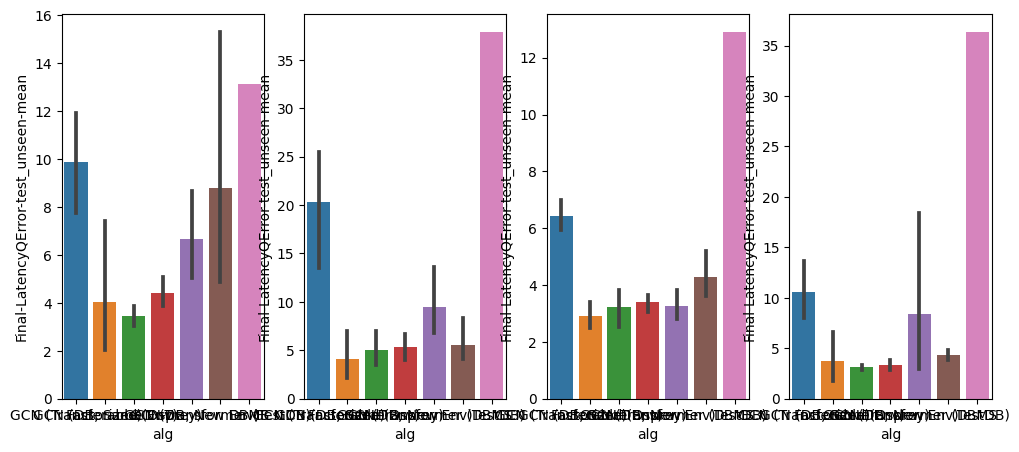

In [910]:
print(set(df["only_workload"]))

WKS = ["ssb", "ccs", "accidents", "airline"]
fig,axs = plt.subplots(nrows=1,ncols=4, figsize=(12,5))

for wi,wk in enumerate(WKS):
    ax = axs[wi]
    tmp = df[df["only_workload"] == wk]
    sns.barplot(data=tmp, x="alg", y='Final-LatencyQError-test_unseen-mean', 
                hue="alg", 
                dodge=False, ax=ax)
    ax.legend().remove()

In [911]:
#tmp = df[df["alg"] == 'GCN-Pretrained-0.0001extra-training-0wd-1-models5/single_allzdbs_logfeats_col.wt']

In [912]:
set(df["only_workload"])

{'accidents',
 'airline',
 'basketball',
 'ccs',
 'consumerexpenditure',
 'credit',
 'financial',
 'seznam',
 'ssb'}

{'Factorized (Osprey)', 'GCN (DB, Same Env)', 'GCN (DB, New Env)', 'DBMS', 'GCN (Transferable)'}
{'Factorized (Osprey)', 'GCN (DB, Same Env)', 'GCN (DB, New Env)', 'DBMS', 'GCN (Transferable)'}
{'Factorized (Osprey)', 'GCN (DB, Same Env)', 'GCN (DB, New Env)', 'DBMS', 'GCN (Transferable)'}


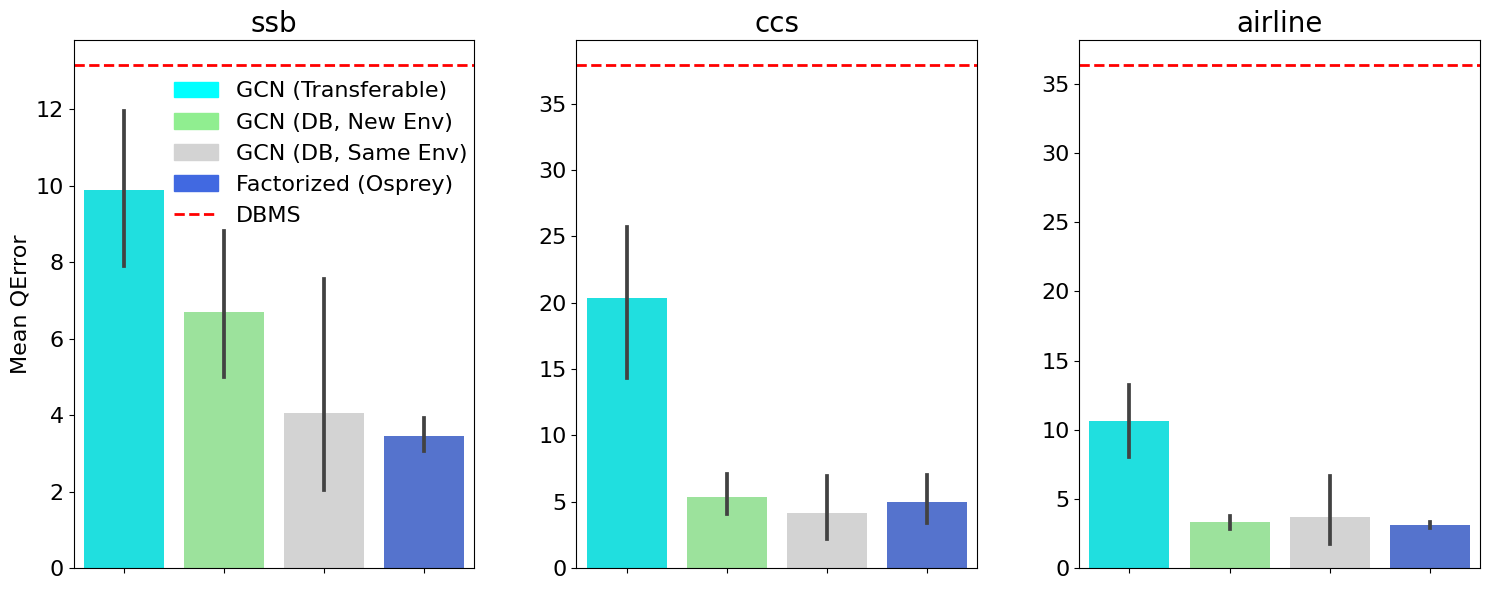

In [913]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df[df["Estimator"] != ""]

# Assuming df is your DataFrame with the relevant columns

ORDER = ["GCN (Transferable)", "GCN (DB, New Env)", "GCN (DB, Same Env)",
         "Factorized (Osprey)"]

WKS = ["ssb", "ccs", "airline"]

#WKS = ["ssb", "ccs", "accidents", "seznam"]

df = df[df["Estimator"].isin(ORDER+BASELINES)]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

# Manually create legend handles for the bar plots
bar_handles = [mpatches.Patch(color=HUES[name], label=name) for name in ORDER]

for wi, wk in enumerate(WKS):
    baseline_handles = []
    ax = axs[wi]
    tmp = df[df["only_workload"] == wk]
    
    print(set(tmp["Estimator"]))
    
    sns_plot = sns.barplot(data=tmp, x="Estimator", 
                           y='Final-LatencyQError-test_unseen-mean', 
                           hue="Estimator", 
                           palette=HUES,
                           order = ORDER,
                           dodge=False, ax=ax)
    
    ax.set_title(wk, fontsize=20)
    
    if wi == 0:
        ax.set_ylabel("Mean QError", fontsize=16)
    else:
        ax.set_ylabel("", fontsize=0)
    
    for estb in BASELINES:
        tmp2 = tmp[tmp["Estimator"] == estb]
        if len(tmp2) == 0:
            continue
        bmean = tmp2['Final-LatencyQError-test_unseen-mean'].mean()
        line = ax.axhline(bmean, color=HUES[estb], linestyle='--', lw=2.0)
        baseline_handles.append(line)
    
    # Remove x-tick labels
    ax.set_xticklabels([])
    ax.set_xlabel("", fontsize=0)
    ax.legend().remove()
    ax.tick_params(axis='y', labelsize=16)
    
    # Manually create the legend
    if baseline_handles:
        custom_handles = bar_handles + baseline_handles 
        custom_labels = ORDER + BASELINES
    else:
        custom_handles = bar_handles
        custom_labels = ORDER
    
    if wi == 0:
        ax.legend(handles=custom_handles, labels=custom_labels, 
           loc='upper left', fontsize=16, ncol=1, frameon=False,
           bbox_to_anchor=(0.2, 0.96))  # Adjust the 0.99 as needed


plt.tight_layout()

plt.savefig("EvalSingle-zdbs.pdf", bbox_inches="tight")
plt.show()

{'Factorized', 'GCN (DB), Same Env', 'GCN (DB), New Env', 'DBMS', 'GCN (Transferable)'}
{'Factorized', 'GCN (DB), Same Env', 'GCN (DB), New Env', 'DBMS', 'GCN (Transferable)'}
{'Factorized', 'GCN (DB), Same Env', 'GCN (DB), New Env', 'DBMS', 'GCN (Transferable)'}
{'Factorized', 'GCN (DB), Same Env', 'GCN (DB), New Env', 'DBMS', 'GCN (Transferable)'}


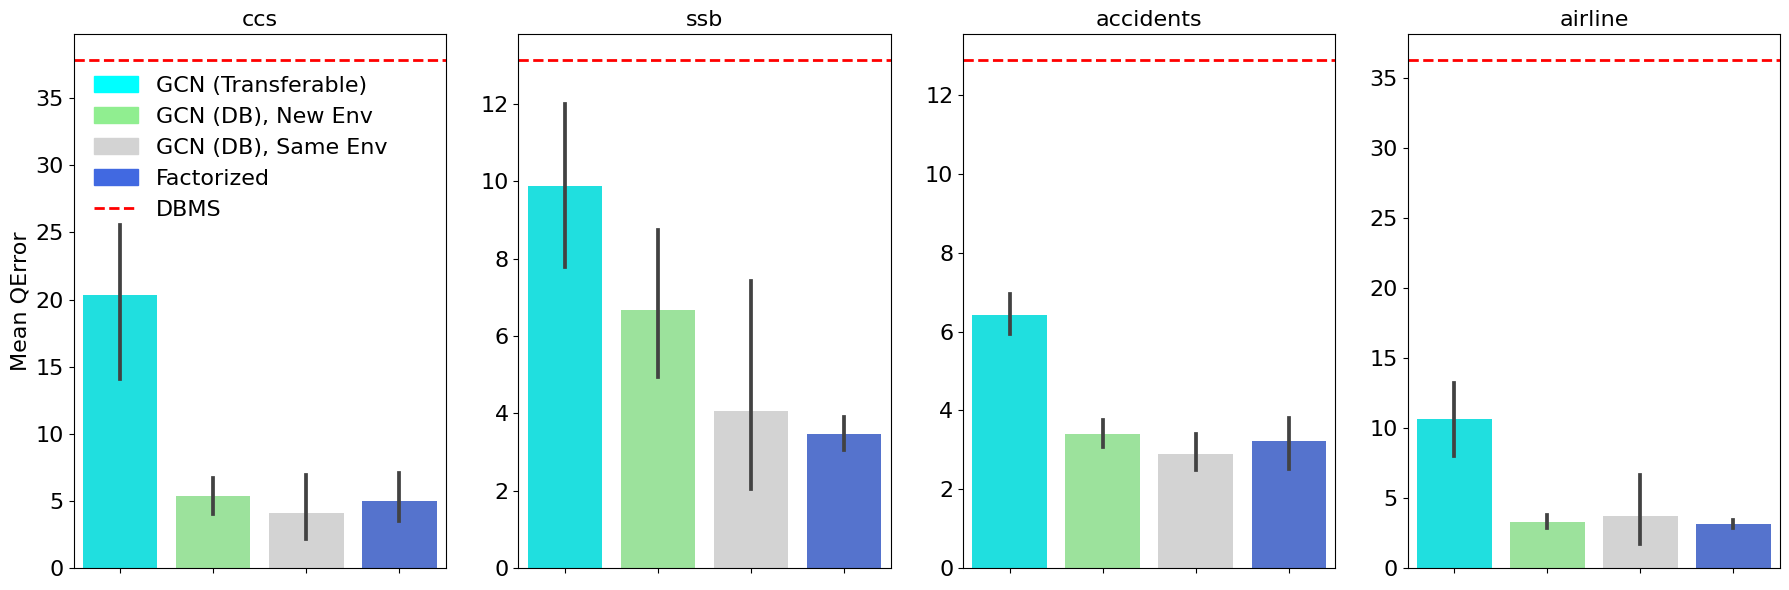

In [868]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df[df["Estimator"] != ""]

# Assuming df is your DataFrame with the relevant columns

ORDER = ["GCN (Transferable)", "GCN (DB, New Env)", "GCN (DB, Same Env)",
         "Factorized (Osprey)"]

WKS = ["ccs", "ssb", "accidents", "airline"]

#WKS = ["ssb", "ccs", "accidents", "seznam"]

df = df[df["Estimator"].isin(ORDER+BASELINES)]

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))

# Manually create legend handles for the bar plots
bar_handles = [mpatches.Patch(color=HUES[name], label=name) for name in ORDER]

for wi, wk in enumerate(WKS):
    baseline_handles = []
    ax = axs[wi]
    tmp = df[df["only_workload"] == wk]
    
    print(set(tmp["Estimator"]))
    
    sns_plot = sns.barplot(data=tmp, x="Estimator", 
                           y='Final-LatencyQError-test_unseen-mean', 
                           hue="Estimator", 
                           palette=HUES,
                           order = ORDER,
                           dodge=False, ax=ax)
    
    ax.set_title(wk, fontsize=16)
    
    if wi == 0:
        ax.set_ylabel("Mean QError", fontsize=16)
    else:
        ax.set_ylabel("", fontsize=0)
    
    for estb in BASELINES:
        tmp2 = tmp[tmp["Estimator"] == estb]
        if len(tmp2) == 0:
            continue
        bmean = tmp2['Final-LatencyQError-test_unseen-mean'].mean()
        line = ax.axhline(bmean, color=HUES[estb], linestyle='--', lw=2.0)
        baseline_handles.append(line)
    
    # Remove x-tick labels
    ax.set_xticklabels([])
    ax.set_xlabel("", fontsize=0)
    ax.legend().remove()
    ax.tick_params(axis='y', labelsize=16)
    
    # Manually create the legend
    if baseline_handles:
        custom_handles = bar_handles + baseline_handles 
        custom_labels = ORDER + BASELINES
    else:
        custom_handles = bar_handles
        custom_labels = ORDER
    
    if wi == 0:
        ax.legend(handles=custom_handles, labels=custom_labels, 
           loc='upper left', fontsize=16, ncol=1, frameon=False,
           bbox_to_anchor=(0.0, 0.96))  # Adjust the 0.99 as needed


plt.tight_layout()

plt.savefig("EvalSingle-zdbs.pdf", bbox_inches="tight")
plt.show()

{'Factorized', 'GCN (DB), Same Env', 'GCN (DB), New Env', 'DBMS', 'GCN (Transferable)'}
{'Factorized', 'GCN (DB), Same Env', 'GCN (DB), New Env', 'DBMS', 'GCN (Transferable)'}
{'Factorized', 'GCN (DB), Same Env', 'GCN (DB), New Env', 'DBMS', 'GCN (Transferable)'}
{'Factorized', 'GCN (DB), Same Env', 'GCN (DB), New Env', 'DBMS', 'GCN (Transferable)'}


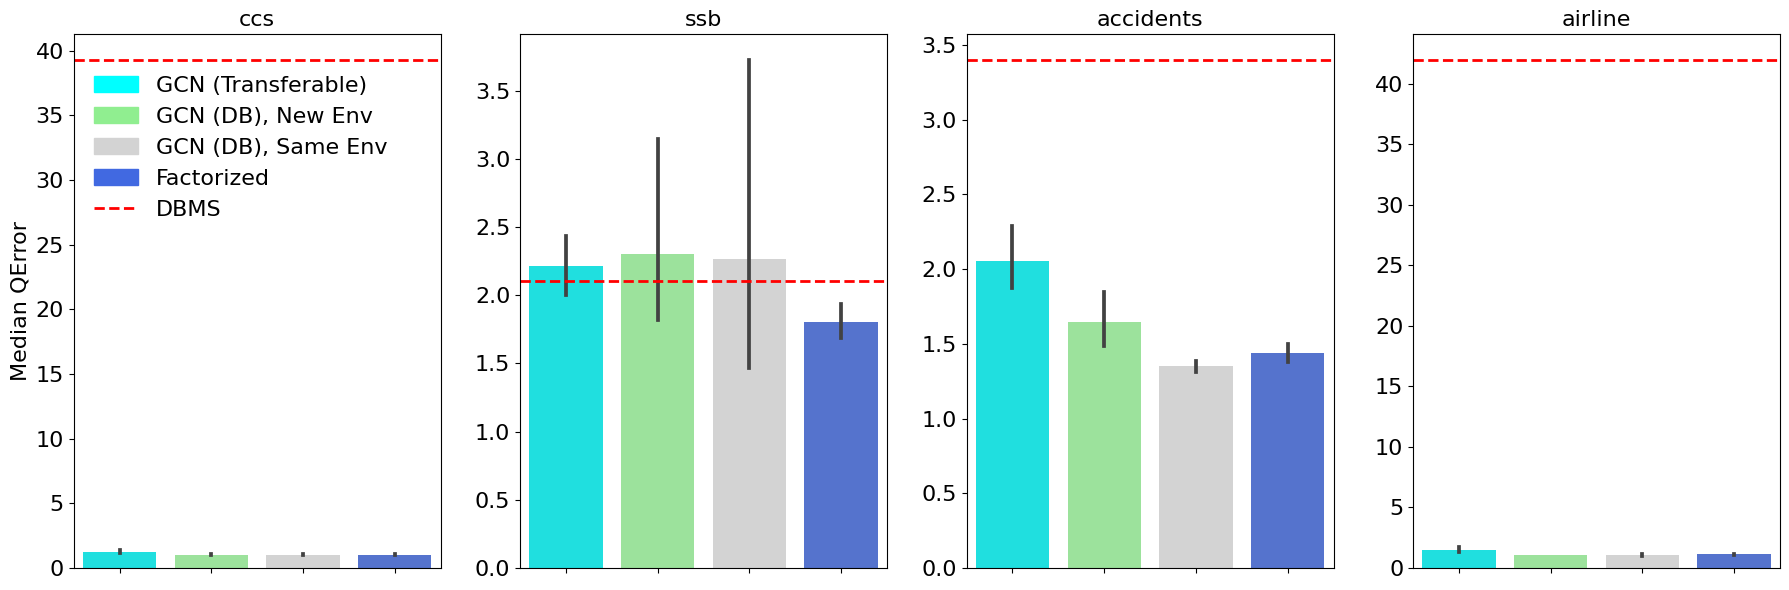

In [870]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df[df["Estimator"] != ""]

# Assuming df is your DataFrame with the relevant columns

ORDER = ["GCN (Transferable)", "GCN (DB, New Env)", "GCN (DB, Same Env)",
         "Factorized (Osprey)"]

WKS = ["ccs", "ssb", "accidents", "airline"]

#WKS = ["ssb", "ccs", "accidents", "seznam"]

df = df[df["Estimator"].isin(ORDER+BASELINES)]

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))

# Manually create legend handles for the bar plots
bar_handles = [mpatches.Patch(color=HUES[name], label=name) for name in ORDER]

for wi, wk in enumerate(WKS):
    baseline_handles = []
    ax = axs[wi]
    tmp = df[df["only_workload"] == wk]
    
    print(set(tmp["Estimator"]))
    
    sns_plot = sns.barplot(data=tmp, x="Estimator", 
                           y='Final-LatencyQError-test_unseen-median', 
                           hue="Estimator", 
                           palette=HUES,
                           order = ORDER,
                           dodge=False, ax=ax)
    
    ax.set_title(wk, fontsize=16)
    
    if wi == 0:
        ax.set_ylabel("Median QError", fontsize=16)
    else:
        ax.set_ylabel("", fontsize=0)
    
    for estb in BASELINES:
        tmp2 = tmp[tmp["Estimator"] == estb]
        if len(tmp2) == 0:
            continue
        bmean = tmp2['Final-LatencyQError-test_unseen-median'].mean()
        line = ax.axhline(bmean, color=HUES[estb], linestyle='--', lw=2.0)
        baseline_handles.append(line)
    
    # Remove x-tick labels
    ax.set_xticklabels([])
    ax.set_xlabel("", fontsize=0)
    ax.legend().remove()
    ax.tick_params(axis='y', labelsize=16)
    
    # Manually create the legend
    if baseline_handles:
        custom_handles = bar_handles + baseline_handles 
        custom_labels = ORDER + BASELINES
    else:
        custom_handles = bar_handles
        custom_labels = ORDER
    
    if wi == 0:
        ax.legend(handles=custom_handles, labels=custom_labels, 
           loc='upper left', fontsize=16, ncol=1, frameon=False,
           bbox_to_anchor=(0.0, 0.96))  # Adjust the 0.99 as needed


plt.tight_layout()

plt.savefig("EvalSingle-zdbs-median.pdf", bbox_inches="tight")
plt.show()

# Other workloads

{'GCN (DB), New Env', 'Factorized', 'GCN (DB), Same Env'}
{'GCN (DB), New Env', 'Factorized'}
{'GCN (DB), New Env', 'Factorized', 'GCN (DB), Same Env'}
{'GCN (DB), New Env', 'Factorized', 'GCN (DB), Same Env'}


IndexError: index 4 is out of bounds for axis 0 with size 4

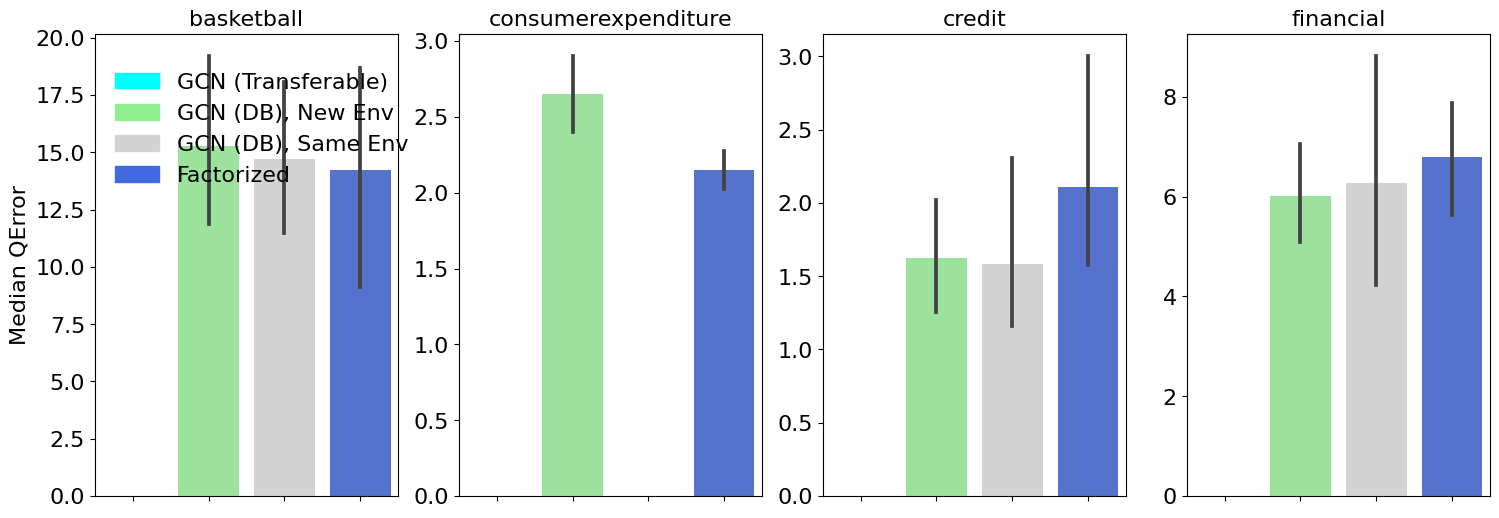

In [884]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df[df["Estimator"] != ""]

# Assuming df is your DataFrame with the relevant columns

ORDER = ["GCN (Transferable)", "GCN (DB, New Env)", "GCN (DB, Same Env)",
         "Factorized (Osprey)"]

#WKS = ["ccs", "ssb", "accidents", "airline"]

#WKS = ["ssb", "ccs", "accidents", "seznam"]

WKS = ["basketball", "consumerexpenditure", "credit", "financial", "seznam"]

df = df[df["Estimator"].isin(ORDER+BASELINES)]

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))

# Manually create legend handles for the bar plots
bar_handles = [mpatches.Patch(color=HUES[name], label=name) for name in ORDER]

for wi, wk in enumerate(WKS):
    baseline_handles = []
    ax = axs[wi]
    tmp = df[df["only_workload"] == wk]
    
    print(set(tmp["Estimator"]))
    
    sns_plot = sns.barplot(data=tmp, x="Estimator", 
                           y='Final-LatencyQError-test_unseen-mean', 
                           hue="Estimator", 
                           palette=HUES,
                           order = ORDER,
                           dodge=False, ax=ax)
    
    ax.set_title(wk, fontsize=16)
    
    if wi == 0:
        ax.set_ylabel("Median QError", fontsize=16)
    else:
        ax.set_ylabel("", fontsize=0)
    
    for estb in BASELINES:
        tmp2 = tmp[tmp["Estimator"] == estb]
        if len(tmp2) == 0:
            continue
        bmean = tmp2['Final-LatencyQError-test_unseen-mean'].mean()
        line = ax.axhline(bmean, color=HUES[estb], linestyle='--', lw=2.0)
        baseline_handles.append(line)
    
    # Remove x-tick labels
    ax.set_xticklabels([])
    ax.set_xlabel("", fontsize=0)
    ax.legend().remove()
    ax.tick_params(axis='y', labelsize=16)
    
    # Manually create the legend
    if baseline_handles:
        custom_handles = bar_handles + baseline_handles 
        custom_labels = ORDER + BASELINES
    else:
        custom_handles = bar_handles
        custom_labels = ORDER
    
    if wi == 0:
        ax.legend(handles=custom_handles, labels=custom_labels, 
           loc='upper left', fontsize=16, ncol=1, frameon=False,
           bbox_to_anchor=(0.0, 0.96))  # Adjust the 0.99 as needed


plt.tight_layout()

plt.savefig("EvalSingle-zdbs-median.pdf", bbox_inches="tight")
plt.show()

{'GCN (DB), New Env', 'Factorized', 'GCN (DB), Same Env'}
{'GCN (DB), New Env', 'Factorized'}
{'GCN (DB), New Env', 'Factorized', 'GCN (DB), Same Env'}
{'GCN (DB), New Env', 'Factorized', 'GCN (DB), Same Env'}


IndexError: index 4 is out of bounds for axis 0 with size 4

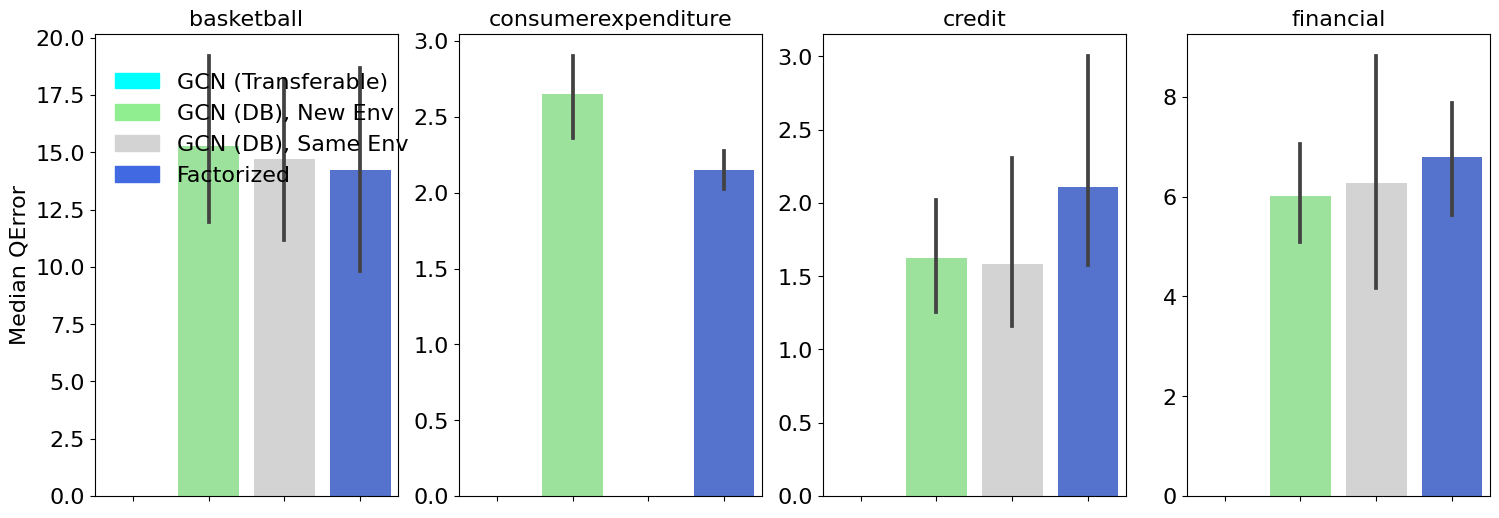

In [872]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df[df["Estimator"] != ""]

# Assuming df is your DataFrame with the relevant columns

ORDER = ["GCN (Transferable)", "GCN (DB, New Env)", "GCN (DB, Same Env)",
         "Factorized (Osprey)"]

#WKS = ["ccs", "ssb", "accidents", "airline"]

#WKS = ["ssb", "ccs", "accidents", "seznam"]

WKS = ["basketball", "consumerexpenditure", "credit", "financial", "seznam"]

df = df[df["Estimator"].isin(ORDER+BASELINES)]

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))

# Manually create legend handles for the bar plots
bar_handles = [mpatches.Patch(color=HUES[name], label=name) for name in ORDER]

for wi, wk in enumerate(WKS):
    baseline_handles = []
    ax = axs[wi]
    tmp = df[df["only_workload"] == wk]
    
    print(set(tmp["Estimator"]))
    
    sns_plot = sns.barplot(data=tmp, x="Estimator", 
                           y='Final-LatencyQError-test_unseen-mean', 
                           hue="Estimator", 
                           palette=HUES,
                           order = ORDER,
                           dodge=False, ax=ax)
    
    ax.set_title(wk, fontsize=16)
    
    if wi == 0:
        ax.set_ylabel("Median QError", fontsize=16)
    else:
        ax.set_ylabel("", fontsize=0)
    
    for estb in BASELINES:
        tmp2 = tmp[tmp["Estimator"] == estb]
        if len(tmp2) == 0:
            continue
        bmean = tmp2['Final-LatencyQError-test_unseen-mean'].mean()
        line = ax.axhline(bmean, color=HUES[estb], linestyle='--', lw=2.0)
        baseline_handles.append(line)
    
    # Remove x-tick labels
    ax.set_xticklabels([])
    ax.set_xlabel("", fontsize=0)
    ax.legend().remove()
    ax.tick_params(axis='y', labelsize=16)
    
    # Manually create the legend
    if baseline_handles:
        custom_handles = bar_handles + baseline_handles 
        custom_labels = ORDER + BASELINES
    else:
        custom_handles = bar_handles
        custom_labels = ORDER
    
    if wi == 0:
        ax.legend(handles=custom_handles, labels=custom_labels, 
           loc='upper left', fontsize=16, ncol=1, frameon=False,
           bbox_to_anchor=(0.0, 0.96))  # Adjust the 0.99 as needed


plt.tight_layout()

plt.savefig("EvalSingle-zdbs-median.pdf", bbox_inches="tight")
plt.show()

In [417]:
set(df["alg"])

{'GCN',
 'GCN (Test Instance Specialized)',
 'GCN-Transformer',
 'Pretrained Environment Transformer'}

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

FN_TMP = "NewInstances-{}-{}.pdf"

# Define a function to check if the values have a large range and should be plotted in log scale
def should_use_log_scale(values):
    return max(values) / min(values) > 1000  # Adjust this threshold if needed
    
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metrics2(data, metric_median, metric_90p, metric_mean, title):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(title)

    # Filter out the baseline data
    baseline_data = data[data['alg'] == "DBMS (instance-tuned)"]
    #data = data[data['alg'] != "DBMS (instance-tuned)"]

    if not baseline_data.empty:
        baseline_median = baseline_data[metric_median].values[0]
        baseline_90p = baseline_data[metric_90p].values[0]
        baseline_mean = baseline_data[metric_mean].values[0]
    else:
        baseline_median = None
        baseline_90p = None
        baseline_mean = None

    metrics = [(metric_median, baseline_median, 'Median'),
               (metric_90p, baseline_90p, '90th Percentile'),
               (metric_mean, baseline_mean, 'Mean')]

    algs = data['alg'].unique()
    colors = sns.color_palette("tab10", len(algs))
    alg_color_map = dict(zip(algs, colors))
    
    bar_width = 0.15
    num_algs = len(algs)
    positions = list(range(len(data['num_instances'].unique())))

    for i, (metric, baseline, metric_name) in enumerate(metrics):
        ax = axs[i]
        for j, alg in enumerate(algs):
            alg_data = data[data['alg'] == alg]
            
            # Positional adjustments for the bars based on their order
            pos = [p + j * bar_width for p in positions]
            
            mean_values = alg_data.groupby("num_instances")[metric].mean()
            min_values = alg_data.groupby("num_instances")[metric].min()
            max_values = alg_data.groupby("num_instances")[metric].max()
            yerr = [mean_values - min_values, max_values - mean_values]
            
            ax.bar(pos, mean_values, bar_width, yerr=yerr, align='center',
                   alpha=0.7, ecolor='black', capsize=10, label=alg, color=alg_color_map[alg])

        if baseline is not None:
            ax.axhline(baseline, color='r', linestyle='--', label='Baseline ({})'.format(metric_name))
        
        ax.set_title(metric_name)
        ax.set_xlabel('Number of Instances')
        ax.set_ylabel(title)
        ax.yaxis.grid(True)
        ax.set_xticks([p + bar_width * (num_algs-1)/2 for p in positions])
        ax.set_xticklabels([1, 2, 3, 4])

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles + [axs[0].lines[0]], labels + ['Baseline'], loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=(len(handles) + 1) // 3)
    
    plt.tight_layout()
    fn = FN_TMP.format("IMDb", title.replace(' ', '-'))
    #plt.savefig(fn, bbox_inches="tight")


# Loop through each unique workload
# for wk in set(df["workload"]):
#     tmp = df[df["workload"] == wk]
    


NewInstances-IMDb-Latency-MSE.pdf
NewInstances-IMDb-Latency-Q-Error.pdf
NewInstances-IMDb-Latency-Relative-Error.pdf
NewInstances-IMDb-Latency-Absolute-Error.pdf


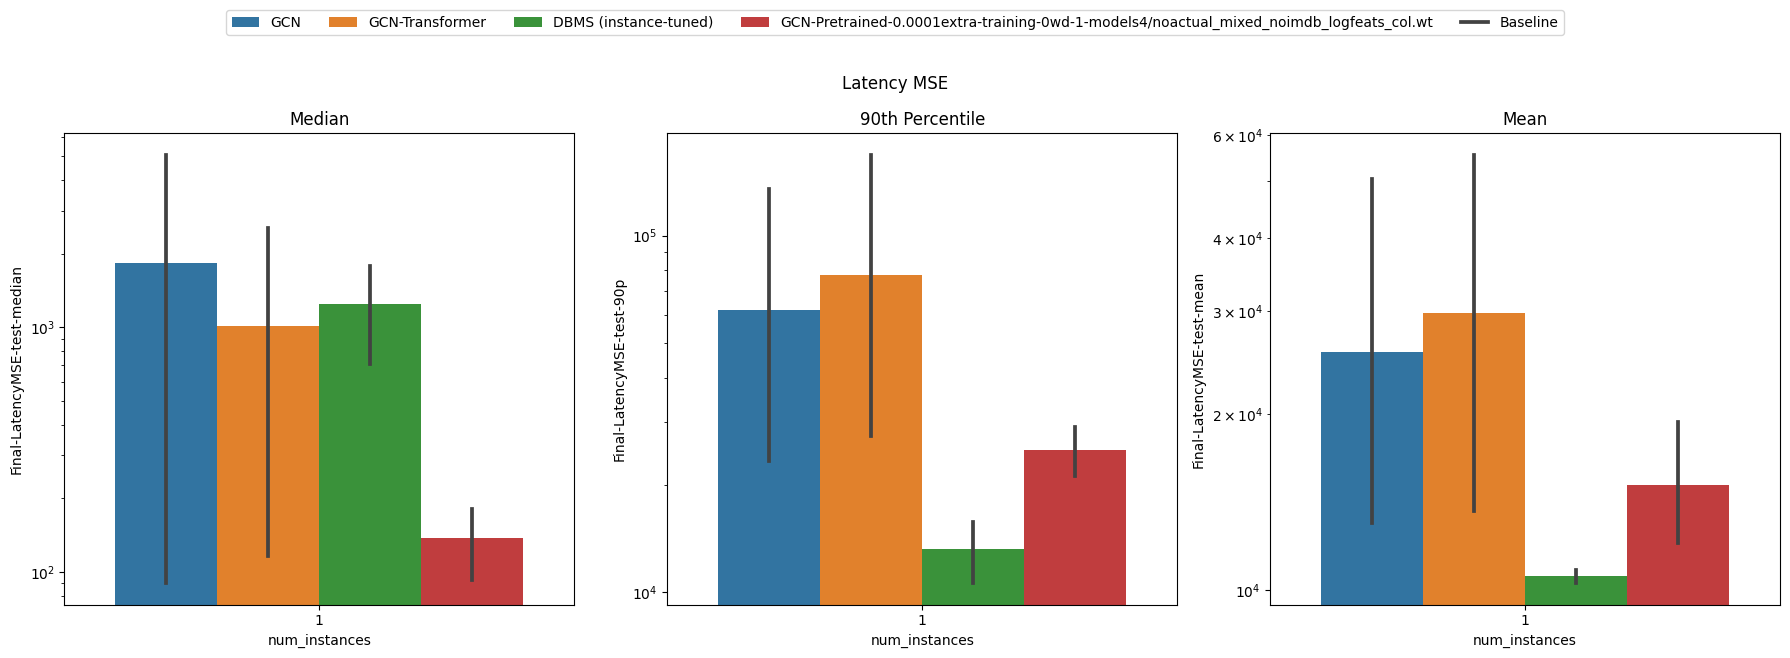

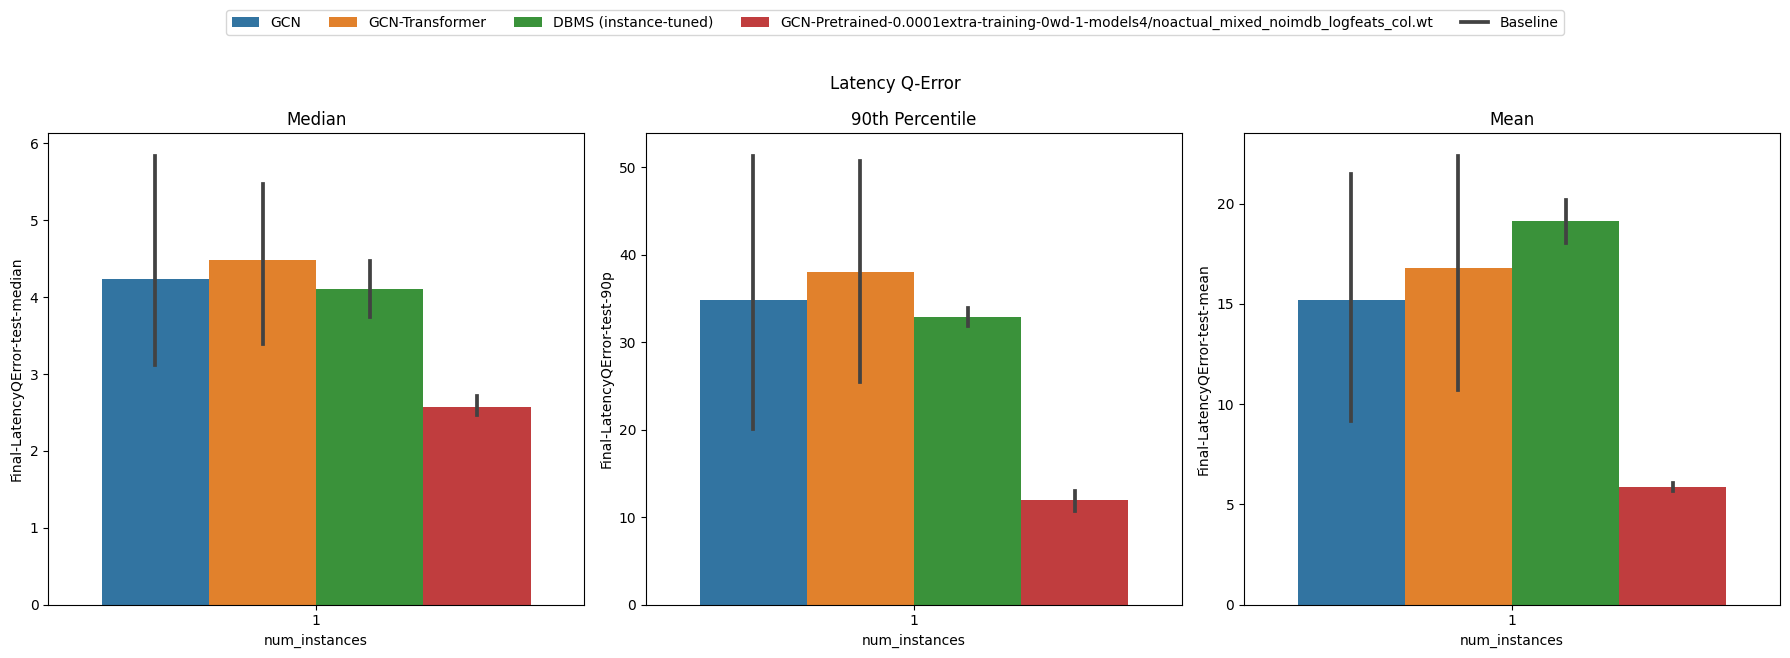

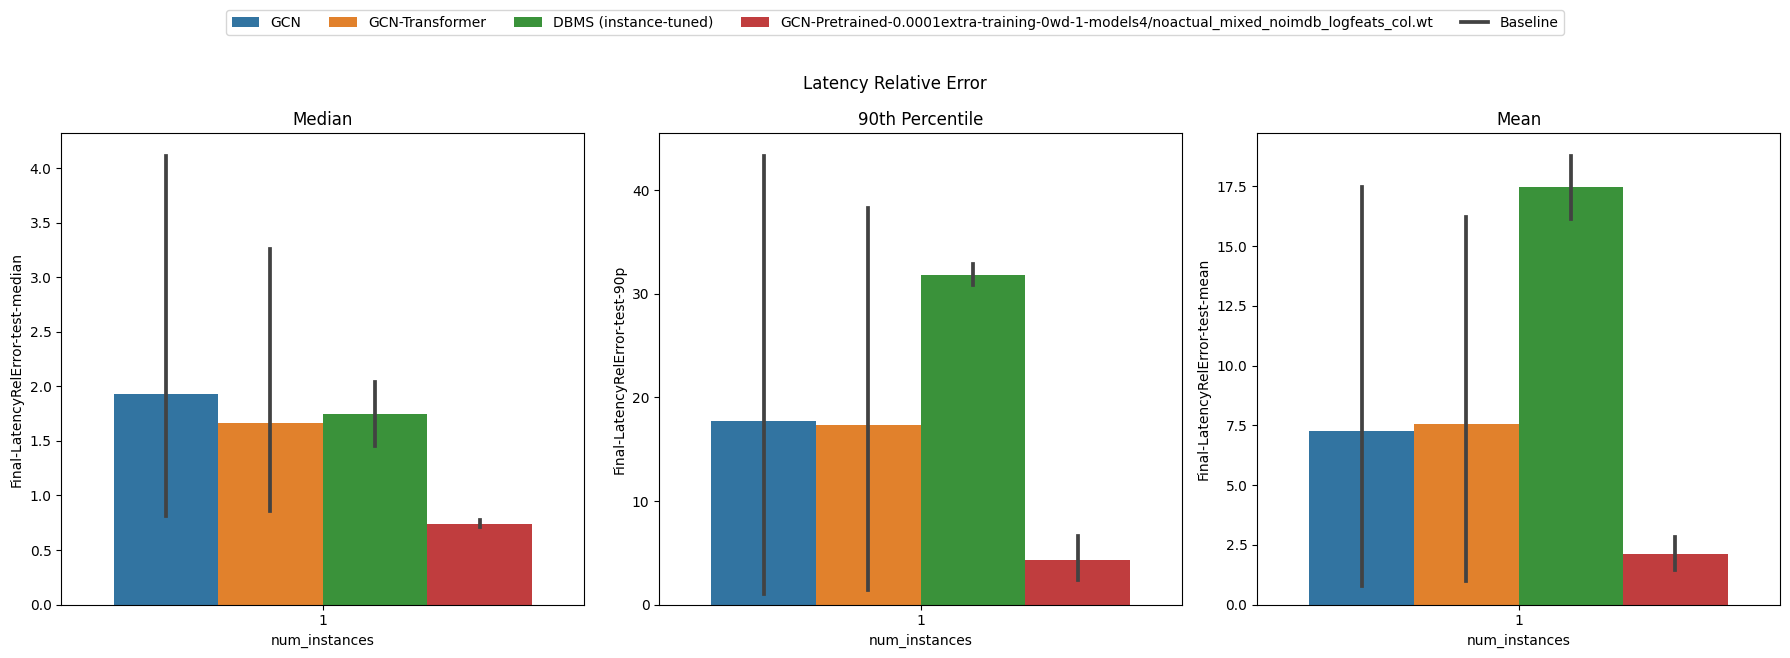

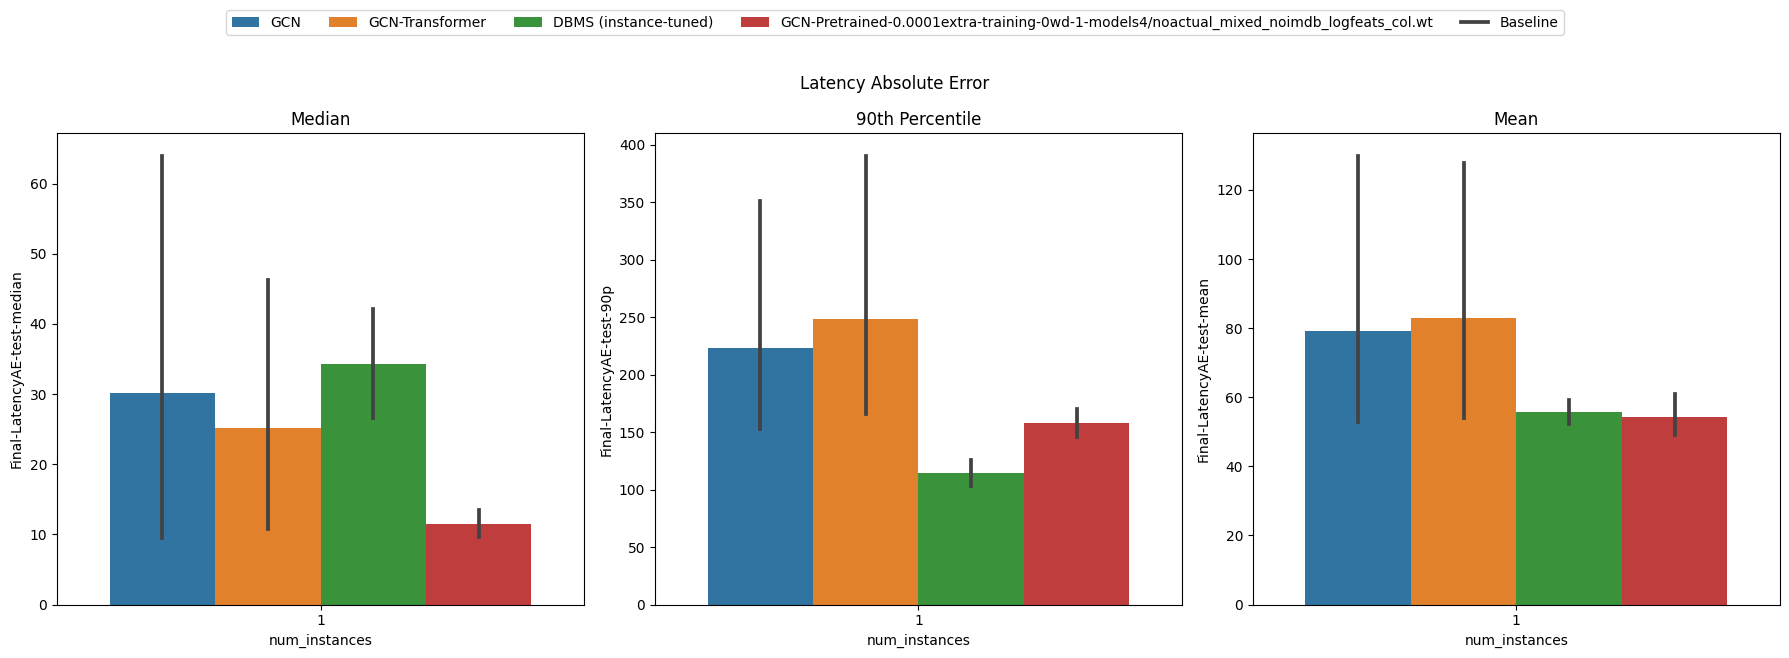

In [81]:

    
tmp = df
# Plot for MSE
plot_metrics(tmp, 
             'Final-LatencyMSE-test-median', 
             'Final-LatencyMSE-test-90p', 
             'Final-LatencyMSE-test-mean',
             'Latency MSE')

# Plot for Q-Error
plot_metrics(tmp, 
             'Final-LatencyQError-test-median', 
             'Final-LatencyQError-test-90p', 
             'Final-LatencyQError-test-mean',
             'Latency Q-Error')

plot_metrics(tmp, 
             'Final-LatencyRelError-test-median', 
             'Final-LatencyRelError-test-90p', 
             'Final-LatencyRelError-test-mean',
             'Latency Relative Error')

# Plot for AE
plot_metrics(tmp, 
             'Final-LatencyAE-test-median', 
             'Final-LatencyAE-test-90p', 
             'Final-LatencyAE-test-mean',
             'Latency Absolute Error')


ValueError: Could not interpret input 'Final-LatencyMSE-test_useen-median'

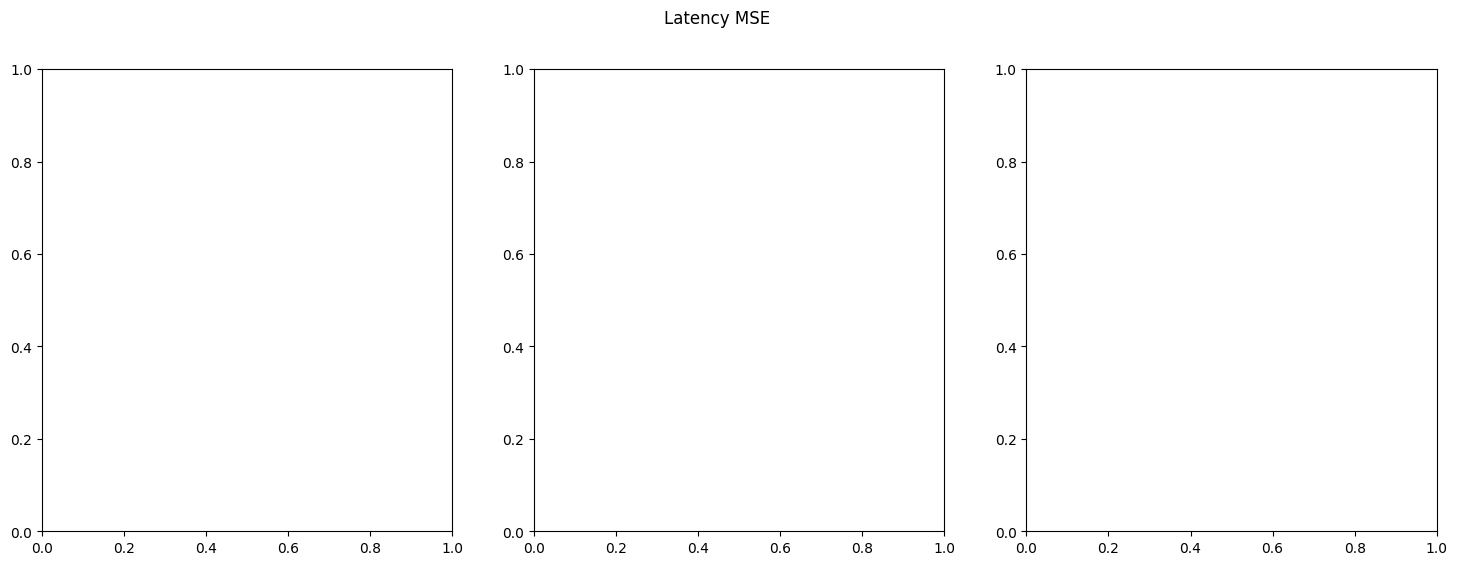

In [82]:
# Loop through each unique workload
# for wk in set(df["workload"]):
#     tmp = df[df["workload"] == wk]
    
tmp = df
# Plot for MSE
plot_metrics(tmp, 
             'Final-LatencyMSE-test_useen-median', 
             'Final-LatencyMSE-test_useen-90p', 
             'Final-LatencyMSE-test_useen-mean',
             'Latency MSE')

# Plot for Q-Error
plot_metrics(tmp, 
             'Final-LatencyQError-test_useen-median', 
             'Final-LatencyQError-test_useen-90p', 
             'Final-LatencyQError-test_useen-mean',
             'Latency Q-Error')

plot_metrics(tmp, 
             'Final-LatencyRelError-test_useen-median', 
             'Final-LatencyRelError-test_useen-90p', 
             'Final-LatencyRelError-test_useen-mean',
             'Latency Relative Error')

# Plot for AE
plot_metrics(tmp, 
             'Final-LatencyAE-test_useen-median', 
             'Final-LatencyAE-test_useen-90p', 
             'Final-LatencyAE-test_useen-mean',
             'Latency Absolute Error')


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of ticklabels (4).

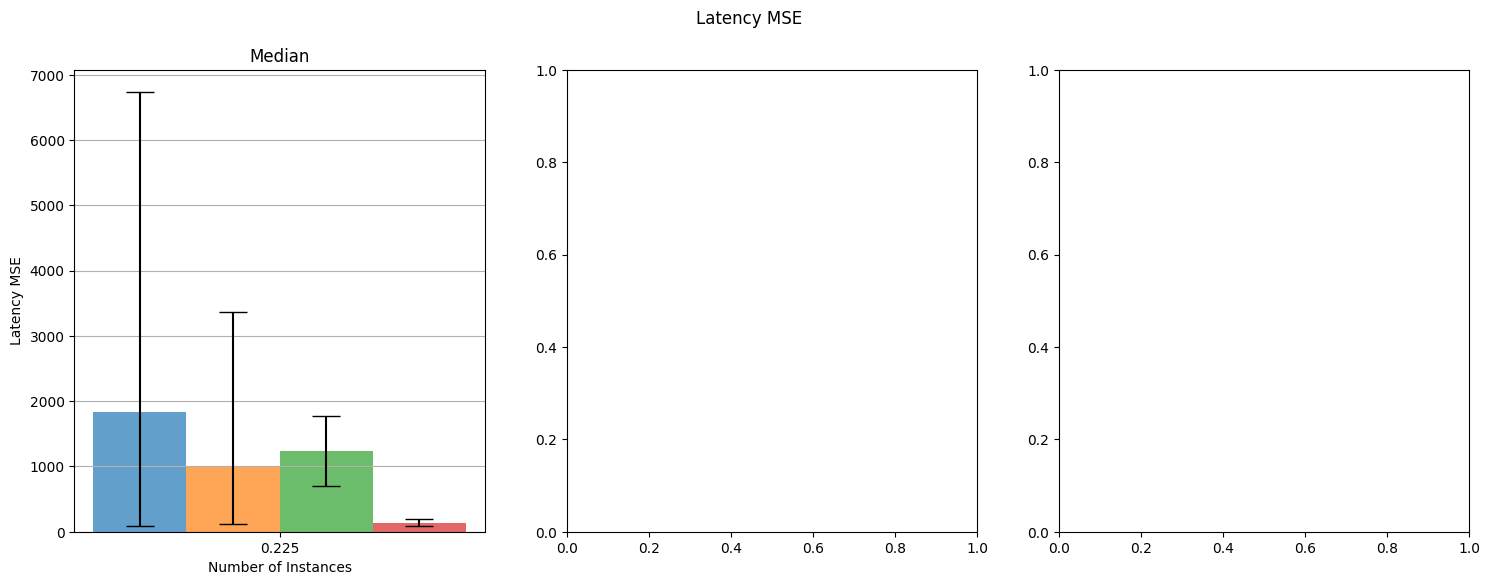

In [83]:
# Plot for MSE
plot_metrics2(tmp, 
             'Final-LatencyMSE-test-median', 
             'Final-LatencyMSE-test-90p', 
             'Final-LatencyMSE-test-mean',
             'Latency MSE')

# Plot for Q-Error
plot_metrics2(tmp, 
             'Final-LatencyQError-test-median', 
             'Final-LatencyQError-test-90p', 
             'Final-LatencyQError-test-mean',
             'Latency Q-Error')

plot_metrics2(tmp, 
             'Final-LatencyRelError-test-median', 
             'Final-LatencyRelError-test-90p', 
             'Final-LatencyRelError-test-mean',
             'Latency Relative Error')

# Plot for AE
plot_metrics2(tmp, 
             'Final-LatencyAE-test-median', 
             'Final-LatencyAE-test-90p', 
             'Final-LatencyAE-test-mean',
             'Latency Absolute Error')


In [22]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Example data for 3 baselines and 5 seeds for each baseline
# baseline_names = ["Baseline1", "Baseline2", "Baseline3"]
# baseline_data = {
#     "Baseline1": [[5, 5.1, 5.8], [5.5, 5.6, 6.1], [6, 6.2, 6.7], [6.1, 6.3, 6.8], [5.9, 6.0, 6.4]],  # Each inner list has [mean, median, 90p]
#     "Baseline2": [[6, 6.1, 6.8], [6.4, 6.5, 7], [6.7, 6.8, 7.3], [6.3, 6.4, 7], [6.1, 6.2, 6.9]],
#     "Baseline3": [[7, 7.1, 7.8], [7.2, 7.3, 8], [7.4, 7.5, 8.2], [7.1, 7.3, 8], [7.2, 7.4, 7.9]]
# }

# means = [np.mean([seed[0] for seed in baseline_data[baseline]]) for baseline in baseline_names]
# medians = [np.mean([seed[1] for seed in baseline_data[baseline]]) for baseline in baseline_names]
# p90s = [np.mean([seed[2] for seed in baseline_data[baseline]]) for baseline in baseline_names]

# # Create bars for means
# bars = plt.bar(baseline_names, means, color='lightblue', label='Mean')

# # Add median points on the bars
# for i, bar in enumerate(bars):
#     plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, medians[i] + 0.1, 'x', ha='center', va='bottom', color='black', fontsize=12, label='Median' if i==0 else "")

# # Add error bars to represent up to the 90p
# plt.errorbar(baseline_names, means, [0]*len(means), [p90 - mean for p90, mean in zip(p90s, means)], fmt='none', ecolor='red', capsize=5, label='90th Percentile')

# plt.ylabel('Value')
# plt.title('Metrics across different baselines')
# plt.legend()
# plt.show()

In [250]:
df[df['alg'] == "DBMS (instance-tuned)"]

,Tags,name,lr,alg,hl1,arch,seed,tags,config,min_est,...,Final-LatencyQError-train-median,Final-LatencyMSE-train-90p,Final-LatencyMSE-test-median,Final-LatencyQError-train-90p,Final-LatencyRelError-test-99p,Final-LatencyRelError-train-median,Final-LatencyAE-train-90p,Final-LatencyMSE-train-mean,test_query_dir,workload
0,"[3a, final5-fixed_instances-min-1]",icy-waterfall-4116,0.00001,DBMS (instance-tuned),512,factorized,1,"exp10_single_zdbs,exp5_single_stats,exp8_singl...",configs/baselines/config_dbms_imdb.yaml,None,...,9.928848,737.231749,179.031049,18.463977,16.435893,8.888694,27.152012,4795.967726,"./queries/ceb-small,./queries/job",Stack


In [178]:
set(df["alg"])

{'DBMS (instance-tuned)',
 'GCN-Pretrained-0.0001extra-training-0wd-0.1-models4/noimdb_actual.wt',
 'GCN-Pretrained-0.0001extra-training-0wd-0.1-models4/noimdb_noactual.wt',
 'GCN-Pretrained-0.0001extra-training-1wd-0.1-models4/noimdb_actual.wt',
 'GCN-Pretrained-1e-05extra-training-0wd-0.1-models4/tpch-ergast-stack_actual.wt',
 'GCN-Pretrained-1e-05extra-training-1wd-0.1-models4/noimdb_noactual.wt',
 'GCN-Pretrained-1e-05extra-training-1wd-0.1-models4/tpch-ergast-stack_actual.wt'}

In [179]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# FN_TMP = "{}-{}.pdf"

# # Define a function to check if the values have a large range and should be plotted in log scale
# def should_use_log_scale(values):
#     return max(values) / min(values) > 100  # Adjust this threshold if needed

# # Define a function to plot the given metrics
# def plot_metrics(data, metric_median, metric_90p, metric_mean, title):
#     fig, axs = plt.subplots(1, 3, figsize=(18,6))
#     plt.suptitle(title)
    
#     # Plot for Median values
#     sns.barplot(data=data, y=metric_median, x="num_instances", hue="alg", dodge=True, ax=axs[0], palette=HUES)
#     axs[0].set_title('Median')
#     if should_use_log_scale(data[metric_median]):
#         axs[0].set_yscale("log")

#     # Plot for 90th Percentile values
#     sns.barplot(data=data, y=metric_90p, x="num_instances", hue="alg", dodge=True, ax=axs[1], palette=HUES)
#     axs[1].set_title('90th Percentile')
#     if should_use_log_scale(data[metric_90p]):
#         axs[1].set_yscale("log")

#     # Plot for Mean values
#     sns.barplot(data=data, y=metric_mean, x="num_instances", hue="alg", dodge=True, ax=axs[2], palette=HUES)
#     axs[2].set_title('Mean')
    
#     if should_use_log_scale(data[metric_mean]):
#         axs[2].set_yscale("log")

#     # Remove individual legends and add a single legend at the top
#     for ax in axs:
#         ax.get_legend().remove()
#     handles, labels = axs[0].get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=len(handles))

#     # Finalize the plot and save
#     plt.tight_layout()
#     fn = FN_TMP.format(wk, title.replace(' ', '-'))
#     print(fn)
#     plt.savefig(fn, bbox_inches="tight")

# # Loop through each unique workload
# for wk in set(df["workload"]):
#     tmp = df[df["workload"] == wk]
    
#     # Plot for MSE
#     plot_metrics(tmp, 
#                  'Final-LatencyMSE-test-median', 
#                  'Final-LatencyMSE-test-90p', 
#                  'Final-LatencyMSE-test-mean',
#                  'Latency MSE')

#     # Plot for Q-Error
#     plot_metrics(tmp, 
#                  'Final-LatencyQError-test-median', 
#                  'Final-LatencyQError-test-90p', 
#                  'Final-LatencyQError-test-mean',
#                  'Latency Q-Error')

    
#     # Plot for Q-Error
#     plot_metrics(tmp, 
#                  'Final-LatencyRelError-test-median', 
#                  'Final-LatencyRelError-test-90p', 
#                  'Final-LatencyRelError-test-mean',
#                  'Latency Relative Error')
    
#     # Plot for AE
#     plot_metrics(tmp, 
#                  'Final-LatencyAE-test-median', 
#                  'Final-LatencyAE-test-90p', 
#                  'Final-LatencyAE-test-mean',
#                  'Latency Absolute Error')

In [180]:
# FN_TMP = "{}-{}.pdf"
# for wk in set(df["workload"]):
#     tmp = df[df["workload"] == wk]
#     EB="ci"
#     TO_PLOT = ['Final-LatencyAE-test-median', 'Final-LatencyAE-test-mean']
#     fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

#     ## train
#     ax = axs[0]
#     sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, 
#                 ax=ax, errorbar=EB, 
#                 palette=HUES)
#     legend = ax.legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
#                        frameon=False)

#     sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=axs[1], 
#                 errorbar=EB, palette=HUES)
#     axs[1].legend().remove()
    
#     fn = FN_TMP.format(wk, "MSE")
#     print(fn)
#     plt.savefig(fn, bbox_inches="tight")
    
#     TO_PLOT = ['Final-LatencyRelError-test-median', 'Final-LatencyRelError-test-90p']
#     fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    
#     ## train
#     sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, ax=axs[0], errorbar=EB,
#                palette=HUES)
#     #axs[0].legend().remove()
#     legend = axs[0].legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
#                frameon=False)
    
#     sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=axs[1], errorbar=EB,
#                palette=HUES)
#     axs[1].legend().remove()
    
#     fn = FN_TMP.format(wk, "Q-Error")
#     print(fn)
#     plt.savefig(fn, bbox_inches="tight")

In [106]:
# FN_TMP = "Test-{}-{}.pdf"
# for wk in set(df["workload"]):
#     tmp = df[df["workload"] == wk]
#     EB="sd"
#     TO_PLOT = ['Final-LatencyAE-train-mean', 'Final-LatencyAE-test-mean']
#     fig,axs = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

#     ## train
# #     ax = axs[0]
# #     sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, 
# #                 ax=ax, errorbar=EB, palette=HUES)
# #     legend = ax.legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
# #                        frameon=False)
    
#     ax = axs
#     sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=ax, 
#                 errorbar=EB, palette=HUES)
#     #axs[1].legend().remove()
#     ax.set_xlabel("Number of training instances", fontsize=20)
#     ax.set_ylabel("Latency AE", fontsize=20)
#     ax.tick_params(axis='both', which='major', labelsize=16)
    
#     fn = FN_TMP.format(wk, "MSE")
#     print(fn)
#     plt.savefig(fn, bbox_inches="tight")
    
#     TO_PLOT = ['Final-LatencyRelError-test-median', 'Final-LatencyRelError-test-90p']
#     fig,axs = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
    
#     ## train
# #     sns.barplot(data=tmp, y=TO_PLOT[0], x="num_instances", hue="alg", dodge=True, ax=axs[0], errorbar=EB,
# #                palette=HUES)
#     #axs[0].legend().remove()
# #     legend = axs[0].legend(loc='upper left', bbox_to_anchor=(0.0,1.20), ncol=2, 
# #                frameon=False)
    
#     ax = axs
#     sns.barplot(data=tmp, y=TO_PLOT[1], x="num_instances", hue="alg", dodge=True, ax=axs, errorbar=EB,
#                palette=HUES)
    
#     ax.set_xlabel("Number of training instances", fontsize=20)
#     ax.set_ylabel("Latency Rel-Error", fontsize=20)
#     ax.tick_params(axis='both', which='major', labelsize=16)
#     #axs[1].legend().remove()
    
#     fn = FN_TMP.format(wk, "Q-Error")
#     print(fn)
#     plt.savefig(fn, bbox_inches="tight")